# Detecting beats in the PPG signal
Beats are detected in the PPG signal in order to segment individual pulse waves for analysis.

---
## Specify an ICU stay and segment

<div class="alert alert-block alert-warning"> <b>Resource:</b> These steps are taken from the <a href="https://wfdb.io/mimic_wfdb_tutorials/tutorial/notebooks/data-visualisation.html">Data Visualisation</a> tutorial. </div>

- Specify the required Python packages

In [19]:
import sys
import wfdb

- Get a list of ICU stays in the database

In [20]:
database_name = 'mimic3wdb/1.0' # The name of the MIMIC III Waveform Database on Physionet (see URL: https://physionet.org/content/mimic3wdb/1.0/)
icustay_records = wfdb.get_record_list(database_name)
print("There are {} ICU stays in the database".format(len(icustay_records)))

There are 67830 ICU stays in the database


- Specify an ICU stay

In [21]:
icustay_no = 10 # specify the first record (noting that in Python the first index is 0)
icustay_record = icustay_records[icustay_no]
icustay_record_dir = database_name + '/' + icustay_record
icustay_record_name = icustay_record.split("/")[1]
print("Specified ICU stay: {}".format(icustay_record_name))

Specified ICU stay: 3000125


- Specify a segment of this ICU stay

In [22]:
icustay_files = wfdb.get_record_list(icustay_record_dir)
icustay_segments = [s for s in icustay_files if "_" in s]
icustay_segment_no = 4;
icustay_segment_name = icustay_segments[icustay_segment_no]
print("Specified segment: '{}' within ICU stay '{}'".format(icustay_segment_name, icustay_record_name))

Specified segment: '3000125_0005' within ICU stay '3000125'


---
## Extract data for this segment
<div class="alert alert-block alert-warning"> <b>Resource:</b> These steps are taken from the <a href="https://wfdb.io/mimic_wfdb_tutorials/tutorial/notebooks/data-visualisation.html">Data Visualisation</a> tutorial. </div>

- Specify the timings of the data to be extracted

In [23]:
start_seconds = 60 # time since the start of the segment at which to begin extracting data
no_seconds_to_load = 5

- Find out the sampling frequency of the waveform data

In [24]:
segment_metadata = wfdb.rdheader(record_name=icustay_segment_name, pn_dir=icustay_record_dir)
fs = segment_metadata.fs

- Extract the specified data

In [25]:
sampfrom = fs*start_seconds
sampto = fs*(start_seconds+no_seconds_to_load)
segment_data = wfdb.rdrecord(record_name=icustay_segment_name, sampfrom=sampfrom, sampto=sampto, pn_dir=icustay_record_dir) 
print("{} seconds of data extracted from: {}".format(no_seconds_to_load, icustay_segment_name))

5 seconds of data extracted from: 3000125_0005


---
## Extract the PPG signal
<div class="alert alert-block alert-warning"> <b>Resource:</b> This step is taken from the <a href="https://wfdb.io/mimic_wfdb_tutorials/tutorial/notebooks/differentiation.html">Differentiation</a> tutorial. </div>

- Extract the PPG signal from the segment data

In [26]:
ppg = segment_data.p_signal[:,2]

---
## Detect beats in the PPG signal

- Import the [HeartPy package](https://python-heart-rate-analysis-toolkit.readthedocs.io/en/latest/), which includes code for detecting beats in PPG signals.

In [27]:
pip install heartpy

Note: you may need to restart the kernel to use updated packages.


In [28]:
import heartpy as hp

- Analyse using HeartPy

In [29]:
working_data, measures = hp.process(ppg, fs)
print("HeartPy estimated the heart rate to be: {:.1f} bpm".format(measures['bpm']))

HeartPy estimated the heart rate to be: 85.6 bpm


- Plot the results using HeartPy's plotting function

/Users/petercharlton/anaconda3/lib/python3.8/site-packages/heartpy/visualizeutils.py:119: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


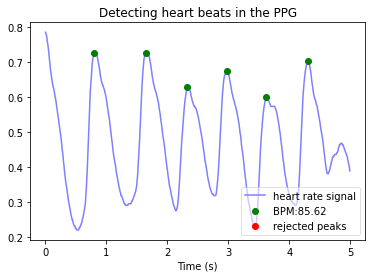

In [30]:
hp.plotter(working_data, measures, title='Detecting heart beats in the PPG')